In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

import scipy.stats as stats
import pylab

In [1]:
def solve_em(f, g, X_0, t, W):
    X_em = np.zeros(W.shape)
    
    X_em[:,0] = X_0
    X_temp = np.copy(X_em[:,0])
    for j in range(1, W.shape[1]):
        W_inc = W[:,j] - W[:,j-1]
        dt = t[j] - t[j-1]
        X_temp = X_temp + dt*f(X_temp) + g(X_temp)*W_inc
        X_em[:,j] = X_temp
    return t, X_em

In [2]:
def brownian_paths(T, N, M):
    dt = T/N
    dW = np.random.normal(0, np.sqrt(dt), size=(M, N))
    dW = np.hstack([np.zeros((M, 1)), dW])
    W = np.cumsum(dW, axis=1)        
    t = np.arange(0, T+dt, dt)
    return t, W

In [0]:
t, Ws = brownian_paths(1, 1000, 3)
lamda = 2
X_0 = 1
mu = 1
f = lambda x: lamda * x
g = lambda x: mu * x
t_em, X_em = solve_em(f, g, X_0, t, Ws)

In [0]:
t, Ws = brownian_paths(20, 80, 500)

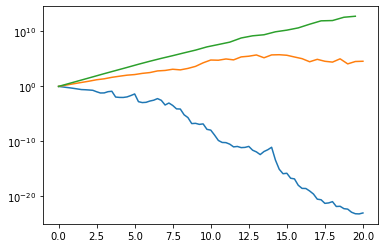

In [0]:
lamda = -3
mu = np.sqrt(3)
f = lambda x: lamda * x
g = lambda x: mu * x
X_0 = 1
t, Ws = brownian_paths(20, 80, 50000)
plt.yscale('log')
plt.yticks(10.**np.arange(-30, 40, 10))
for i in [1,2,3]:
    dt = (20/80)*i
    t_em, W_em = solve_em(f, g, X_0, t[::i], Ws[:,::i])
    plt.plot(t_em, np.mean(W_em**2, axis=0), label=str(dt))

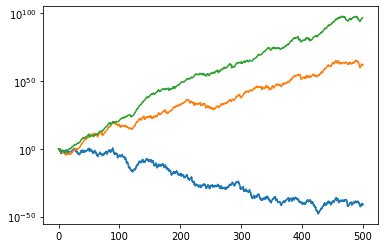

In [0]:
lamda = 1/2
mu = np.sqrt(6)
f = lambda x: lamda * x
g = lambda x: mu * x
X_0 = 1
t, Ws = brownian_paths(500, 2000, 1)
plt.yscale('log')
plt.yticks(10.**np.array([-50, 0, 50, 100]))
for i in [1,2,3]:
    dt = (20/80)*i
    t_em, W_em = solve_em(f, g, X_0, t[::i], Ws[:,::i])
    plt.plot(t_em, np.mean(np.abs(W_em), axis=0), label=str(dt))

# CIR convergence and stability


In [4]:
def cir_dereich(k, lamda, theta, X_0, t, W):
    
    alpha = (4*k*lamda - theta**2)/8
    beta = -k/2
    gamma = theta/2

    Y_sol = np.zeros(W.shape)
    
    Y_sol[:,0] = np.sqrt(X_0)
    Y_temp = np.repeat(np.sqrt(X_0), W.shape[0])
    #set_trace()
    for k in range(1, W.shape[1]):
        W_inc = W[:,k] - W[:,k-1]
        dt = t[k] - t[k-1]
        Y_temp = (Y_temp + gamma*W_inc)/(2*(1-beta*dt)) \
                 + np.sqrt(
                     (Y_temp + gamma*W_inc)**2/(4*(1-beta*dt)**2) \
                     + (alpha*dt)/(1-beta*dt)
                 )
        Y_sol[:,k] = Y_temp
    X_sol = Y_sol**2
    return t, X_sol

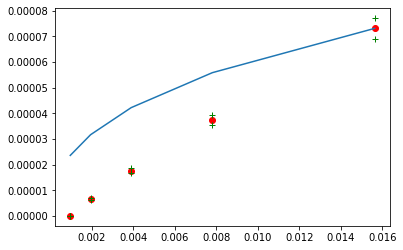

In [9]:
lamda = 0.2
k = 3
theta = 0.01
assert 2*k*lamda > theta**2
p = 1

N = 2**10
T = 1
M = 100 

X_0 = lamda

t_org, Ws = brownian_paths(T, N, M)
t_ref, X_ref = cir_dereich(k, lamda, theta, X_0, t_org, Ws)

stepsizes = 2**np.arange(0, 5)
dt_vals = (T/N)*stepsizes
X_err = np.zeros((M, len(stepsizes)))

for i, stepsize in enumerate(stepsizes):
    t, X = cir_dereich(k, lamda, theta, X_0, t_org[::stepsize], Ws[:,::stepsize])
    X_err[:,i] = np.amax(np.abs(X - X_ref[:,::stepsize])**p, axis=1)

X_err = X_err**(1/p)

E = X_err.mean(axis=0)
E_upper = E + 1.96*np.std(X_err, axis=0)/np.sqrt(X_err.shape[0])
E_lower = E - 1.96*np.std(X_err, axis=0)/np.sqrt(X_err.shape[0])


plt.plot(dt_vals, E, "ro")
plt.plot(dt_vals, E_upper, "g+")
plt.plot(dt_vals, E_lower, "g+")
Kp = np.max( E / (np.sqrt(np.abs(np.log(dt_vals))) * np.sqrt(dt_vals)   ))

plt.plot(dt_vals, Kp*(np.sqrt(np.abs(np.log(dt_vals))) * np.sqrt(dt_vals)   ))